In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np 
import gdal

In [ ]:
"""
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y

import gdal 
"""

In [ ]:
pip install patchify

**Layers**

In [ ]:
import tensorflow as tf


def double_conv(inputs_conv,filters):
    
    #first conv
    conv1 = tf.keras.layers.Conv3D(filters,kernel_size=3, padding='same')(inputs_conv)
    batch1 = tf.keras.layers.BatchNormalization()(conv1)
    relu = tf.keras.layers.Activation('relu')(batch1)
    
    #second conv
    conv2 = tf.keras.layers.Conv3D(filters,kernel_size=3, padding='same')(relu)
    batch2 = tf.keras.layers.BatchNormalization()(conv2)
    relu2 = tf.keras.layers.Activation('relu')(batch2)
    
    return relu2
    

def unet_encoder(inputs_encoder, filters):

    #double conv output
    conv = double_conv(inputs_encoder,filters)

    #pooling
    pool = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(conv)

    return conv, pool

def unet_decoder(inputs_decoder,filters,previous_conv):
    
    deconv = tf.keras.layers.Conv3DTranspose(filters,kernel_size=2,strides=(2,2,2),padding="same")(inputs_decoder)
    concat = tf.keras.layers.Concatenate()([previous_conv,deconv])
    decoder = double_conv(concat, filters)
    
    return decoder




**3D U-Net**

In [ ]:
def unet_model(inputs, filters):

    input_intermediate = tf.keras.Input(inputs)
    
    #Encoder
    conv1, pool1 = unet_encoder(input_intermediate, filters)
    conv2, pool2 = unet_encoder(pool1, filters*2)
    conv3, pool3 = unet_encoder(pool2, filters*4)
    conv4, pool4 = unet_encoder(pool3, filters*8)
    

    #Bottleneck 
    bn, _ = unet_encoder(pool4, filters*16)

    #Decoder
    deconv1 = unet_decoder(bn, filters*8, conv4)
    deconv2 = unet_decoder(deconv1, filters*4, conv3)
    deconv3 = unet_decoder(deconv2, filters*2, conv2)
    deconv4 = unet_decoder(deconv3, filters, conv1)


    out = tf.keras.layers.Conv2D(4,kernel_size=3,padding='same', activation = 'softmax')(deconv4)
    model = tf.keras.Model(inputs=input_intermediate, outputs=out)

    return model
    

In [ ]:
img_size = (64,64,64,3)
filters = 64
unet = unet_model(img_size,filters)

In [ ]:
unet.summary()

**The dataset**

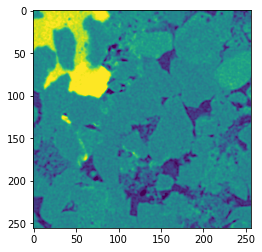

In [ ]:
import matplotlib.pyplot as plt
im = gdal.Open('/content/drive/MyDrive/sandstone_data_for_ML.zip (Unzipped Files)/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif')
img = im.ReadAsArray()
plt.imshow(img) 

In [ ]:
from patchify import patchify 
from skimage import io

img_patches = patchify(io.imread('/content/drive/MyDrive/sandstone_data_for_ML.zip (Unzipped Files)/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif'), (64, 64, 64), step=64)

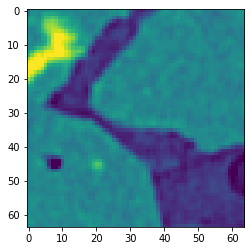

In [ ]:
plt.imshow(img_patches[1,2,3,:,:,32])

In [ ]:
mask_patches = patchify(io.imread('/content/drive/MyDrive/sandstone_data_for_ML.zip (Unzipped Files)/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif'),(64, 64, 64), step=64)

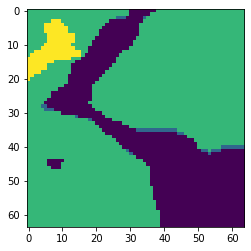

In [ ]:
plt.imshow(mask_patches[1,2,3,:,:,32])

In [ ]:
from keras import backend as K

def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
img_patches.shape

(4, 4, 4, 64, 64, 64)

In [ ]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

In [ ]:
input_img.shape

(64, 64, 64, 64)

In [ ]:
train_img = np.stack((input_img,)*3,axis=4) #(64, 64, 64, 64) --> (64, 64, 64, 64, 3)
train_img = train_img/255

train_mask = np.expand_dims(input_mask, axis=4) #(64, 64, 64, 64) --> (64, 64, 64, 64, 1)

In [ ]:
from sklearn.model_selection import train_test_split

train_mask_cat = tf.keras.utils.to_categorical(train_mask, num_classes=4)
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)

**training**

In [ ]:
optim = tf.keras.optimizers.Adam()
unet.compile(optimizer = optim, loss=dice_coefficient_loss, metrics=dice_coefficient)

In [ ]:
history=unet.fit(X_train, y_train, batch_size=4, epochs=25, verbose=1, validation_data=(X_test, y_test))

Epoch 1/25
15/15 [==============================] - 130s 7s/step - loss: 0.2622 - dice_coefficient: 0.7450 - val_loss: 0.9521 - val_dice_coefficient: 0.0489
Epoch 2/25
15/15 [==============================] - 90s 6s/step - loss: 0.0950 - dice_coefficient: 0.9040 - val_loss: 0.3935 - val_dice_coefficient: 0.6071
Epoch 3/25
15/15 [==============================] - 91s 6s/step - loss: 0.0748 - dice_coefficient: 0.9242 - val_loss: 0.3194 - val_dice_coefficient: 0.6765
Epoch 4/25
15/15 [==============================] - 92s 6s/step - loss: 0.0754 - dice_coefficient: 0.9208 - val_loss: 0.7323 - val_dice_coefficient: 0.2679
Epoch 5/25
15/15 [==============================] - 90s 6s/step - loss: 0.0698 - dice_coefficient: 0.9312 - val_loss: 0.2068 - val_dice_coefficient: 0.7895
Epoch 6/25
15/15 [==============================] - 91s 6s/step - loss: 0.0706 - dice_coefficient: 0.9300 - val_loss: 0.1974 - val_dice_coefficient: 0.7992
Epoch 7/25
15/15 [==============================] - 92s 6s/step

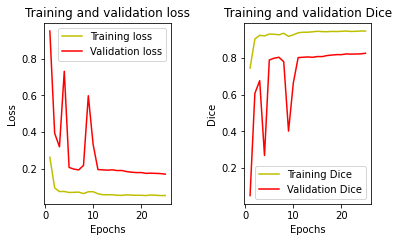

In [ ]:
plt.subplot(1,2,1)



loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout(pad=3)



In [ ]:
y_pred=unet.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)

In [ ]:
from keras.metrics import MeanIoU
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.2867698


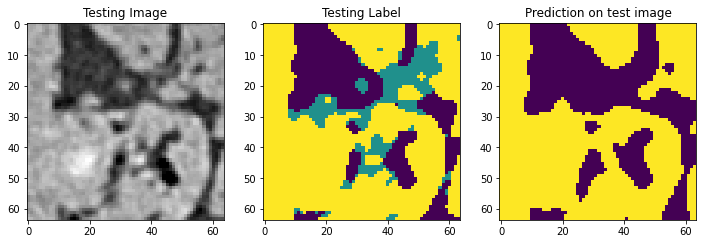

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)


test_pred = unet.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=4)[0,:,:,:]

ground_truth_argmax = np.argmax(ground_truth, axis=3)

slice = random.randint(0, ground_truth_argmax.shape[2]-1)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[slice,:,:])
plt.show()

In [ ]:
large_image = io.imread('/content/drive/MyDrive/sandstone_data_for_ML.zip (Unzipped Files)/sandstone_data_for_ML/data_for_3D_Unet/448_images_512x512.tif')
patches = patchify(large_image, (64, 64, 64), step=64) 

In [ ]:
patches.shape

(7, 8, 8, 64, 64, 64)

In [ ]:
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch = single_patch_3ch/255.
      single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
      single_patch_prediction = unet.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)
      

In [ ]:
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(448, 64, 64, 64)


In [ ]:
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)


(7, 8, 8, 64, 64, 64)


In [ ]:
from patchify import unpatchify
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)

In [ ]:
print(reconstructed_image.shape)

(448, 512, 512)


In [ ]:
reconstructed_image=reconstructed_image.astype(np.uint8)

In [ ]:
from tifffile import imsave
imsave('/content/drive/MyDrive/448_images_segmented.tif', reconstructed_image)

In [ ]:
print(np.unique(reconstructed_image))
len(np.unique(reconstructed_image))

[0 1 2]


3

In [ ]:
num_segments=3
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)


final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
final[:,:,:,0] = segm0
final[:,:,:,1] = segm1
final[:,:,:,2] = segm2

In [ ]:
pip install apeer-ometiff-library

In [ ]:
from apeer_ometiff_library import io

final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)

Shape of the segmented volume is: T, Z, C, X, Y  (1, 448, 3, 512, 512)
int8


In [ ]:
io.write_ometiff("/content/drive/MyDrive/448_segmented_multi_channel.ome.tiff", final)